In [4]:
# Mount the Google Drive to access filesre.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Navigate to the directory containing the dataset
%cd /content/drive/MyDrive/Emotion AI Dataset/

/content/drive/MyDrive/Emotion AI Dataset


In [6]:
# Import the necessary libraries and modules
import pandas as pd
import numpy as np
import os
import PIL
import seaborn as sns
import pickle
from PIL import *
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow

In [7]:
# Load the dataset containing facial keypoints
keyfacial_df = pd.read_csv('/content/drive/MyDrive/Emotion AI Dataset/data.csv')


In [8]:
# Display basic information about the dataframe
keyfacial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          2140 non-null   float64
 1   left_eye_center_y          2140 non-null   float64
 2   right_eye_center_x         2140 non-null   float64
 3   right_eye_center_y         2140 non-null   float64
 4   left_eye_inner_corner_x    2140 non-null   float64
 5   left_eye_inner_corner_y    2140 non-null   float64
 6   left_eye_outer_corner_x    2140 non-null   float64
 7   left_eye_outer_corner_y    2140 non-null   float64
 8   right_eye_inner_corner_x   2140 non-null   float64
 9   right_eye_inner_corner_y   2140 non-null   float64
 10  right_eye_outer_corner_x   2140 non-null   float64
 11  right_eye_outer_corner_y   2140 non-null   float64
 12  left_eyebrow_inner_end_x   2140 non-null   float64
 13  left_eyebrow_inner_end_y   2140 non-null   float

In [9]:
# Check for null values in the dataset
keyfacial_df.isnull().sum()

left_eye_center_x            0
left_eye_center_y            0
right_eye_center_x           0
right_eye_center_y           0
left_eye_inner_corner_x      0
left_eye_inner_corner_y      0
left_eye_outer_corner_x      0
left_eye_outer_corner_y      0
right_eye_inner_corner_x     0
right_eye_inner_corner_y     0
right_eye_outer_corner_x     0
right_eye_outer_corner_y     0
left_eyebrow_inner_end_x     0
left_eyebrow_inner_end_y     0
left_eyebrow_outer_end_x     0
left_eyebrow_outer_end_y     0
right_eyebrow_inner_end_x    0
right_eyebrow_inner_end_y    0
right_eyebrow_outer_end_x    0
right_eyebrow_outer_end_y    0
nose_tip_x                   0
nose_tip_y                   0
mouth_left_corner_x          0
mouth_left_corner_y          0
mouth_right_corner_x         0
mouth_right_corner_y         0
mouth_center_top_lip_x       0
mouth_center_top_lip_y       0
mouth_center_bottom_lip_x    0
mouth_center_bottom_lip_y    0
Image                        0
dtype: int64

In [10]:
# Verify the shape of the 'Image' column
keyfacial_df['Image'].shape


(2140,)

In [11]:
# Convert image data from a space-separated string into a 2D numpy array with shape (96, 96)
keyfacial_df['Image'] = keyfacial_df['Image'].apply(lambda x: np.fromstring(x, dtype=int, sep=' ').reshape(96, 96))


In [12]:
# Display the shape of the first image
keyfacial_df['Image'][0].shape

(96, 96)

In [13]:
# Provide summary statistics for the dataset
keyfacial_df.describe()

left_eye_center_x  left_eye_center_y  right_eye_center_x  \
count        2140.000000        2140.000000         2140.000000   
mean           66.221549          36.842274           29.640269   
std             2.087683           2.294027            2.051575   
min            47.835757          23.832996           18.922611   
25%            65.046300          35.468842           28.472224   
50%            66.129065          36.913319           29.655440   
75%            67.332093          38.286438           30.858673   
max            78.013082          46.132421           42.495172   

       right_eye_center_y  left_eye_inner_corner_x  left_eye_inner_corner_y  \
count         2140.000000              2140.000000              2140.000000   
mean            37.063815                59.272128                37.856014   
std              2.234334                 2.005631                 2.034500   
min             24.773072                41.779381                27.190098   
25%             35.818377                58.113054                36.607950   
50%             37.048085                59.327154                37.845220   
75%             38.333884                60.521492                39.195431   
max             45.980981                69.023030                47.190316   

       left_eye_outer_corner_x  left_eye_outer_corner_y  \
count              2140.000000              2140.000000   
mean                 73.412473                37.640110   
std                   2.701639                 2.684162   
min                  52.947144                26.250023   
25%                  71.741978                36.102409   
50%                  73.240045                37.624207   
75%                  74.978684                39.308331   
max                  87.032252                49.653825   

       right_eye_inner_corner_x  right_eye_inner_corner_y  ...   nose_tip_x  \
count               2140.000000               2140.000000  ...  2140.000000   
mean                  36.603107                 37.920852  ...    47.952141   
std                    1.822784                  2.009505  ...     3.276053   
min                   24.112624                 26.250023  ...    24.472590   
25%                   35.495730                 36.766783  ...    46.495330   
50%                   36.620735                 37.920336  ...    47.900511   
75%                   37.665280                 39.143921  ...    49.260657   
max                   47.293746                 44.887301  ...    65.279654   

        nose_tip_y  mouth_left_corner_x  mouth_left_corner_y  \
count  2140.000000          2140.000000          2140.000000   
mean     57.253926            63.419076            75.887660   
std       4.528635             3.650131             4.438565   
min      41.558400            43.869480            57.023258   
25%      54.466000            61.341291            72.874263   
50%      57.638582            63.199057            75.682465   
75%      60.303524            65.302398            78.774969   
max      75.992731            84.767123            94.673637   

       mouth_right_corner_x  mouth_right_corner_y  mouth_center_top_lip_x  \
count           2140.000000           2140.000000             2140.000000   
mean              32.967365             76.134065               48.081325   
std                3.595103              4.259514                2.723274   
min                9.778137             56.690208               32.260312   
25%               30.879288             73.280038               46.580004   
50%               33.034022             75.941985               47.939031   
75%               35.063575             78.884031               49.290000   
max               50.973348             93.443176               61.804506   

       mouth_center_top_lip_y  mouth_center_bottom_lip_x  \
count             2140.000000                2140.000000   
mean                72.681125                  48.149654

<ipython-input-14-ee65aa9db0be>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(keyfacial_df.loc[i][j-1], keyfacial_df.loc[i][j], 'rx')


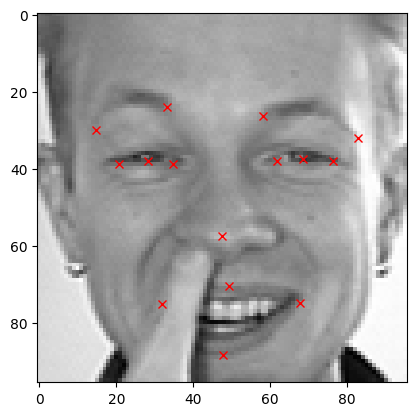

In [14]:
# Plot a random image along with facial keypoints
# The x and y coordinates are extracted from alternating columns in the dataframe
i = np.random.randint(1, len(keyfacial_df))
plt.imshow(keyfacial_df['Image'][i], cmap='gray')
for j in range(1, 31, 2):
    plt.plot(keyfacial_df.loc[i][j-1], keyfacial_df.loc[i][j], 'rx')

<ipython-input-15-c6b2b7e7f28f>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(keyfacial_df.loc[i][j-1], keyfacial_df.loc[i][j], 'rx')


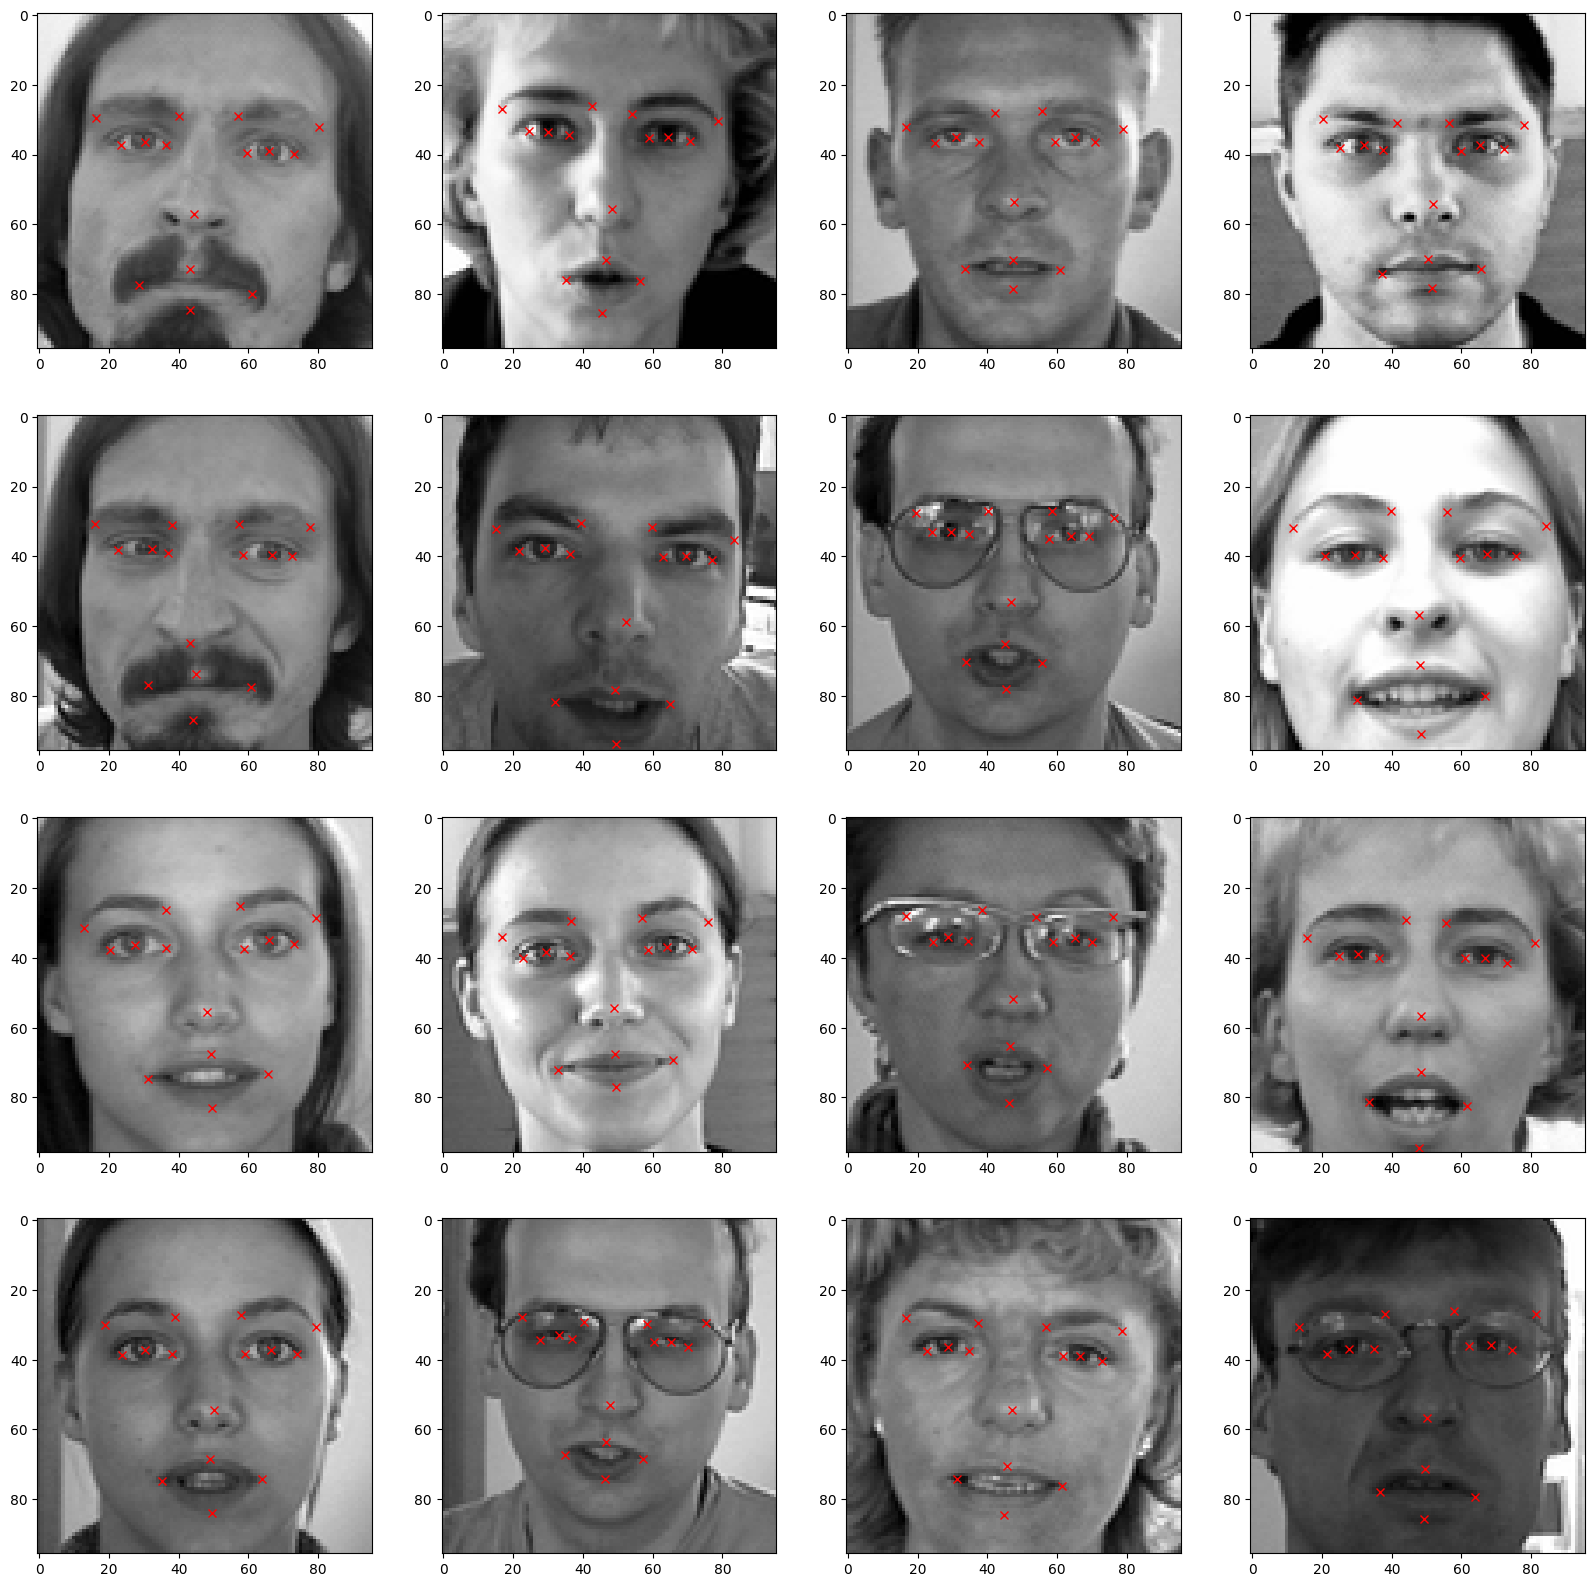

In [15]:
# Display multiple images in a grid format
fig = plt.figure(figsize=(20, 20))
for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1)
    image = plt.imshow(keyfacial_df['Image'][i], cmap='gray')
    for j in range(1, 31, 2):
        plt.plot(keyfacial_df.loc[i][j-1], keyfacial_df.loc[i][j], 'rx')

<ipython-input-16-040902e63cfe>:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(keyfacial_df.loc[k][j-1], keyfacial_df.loc[k][j], 'rx')


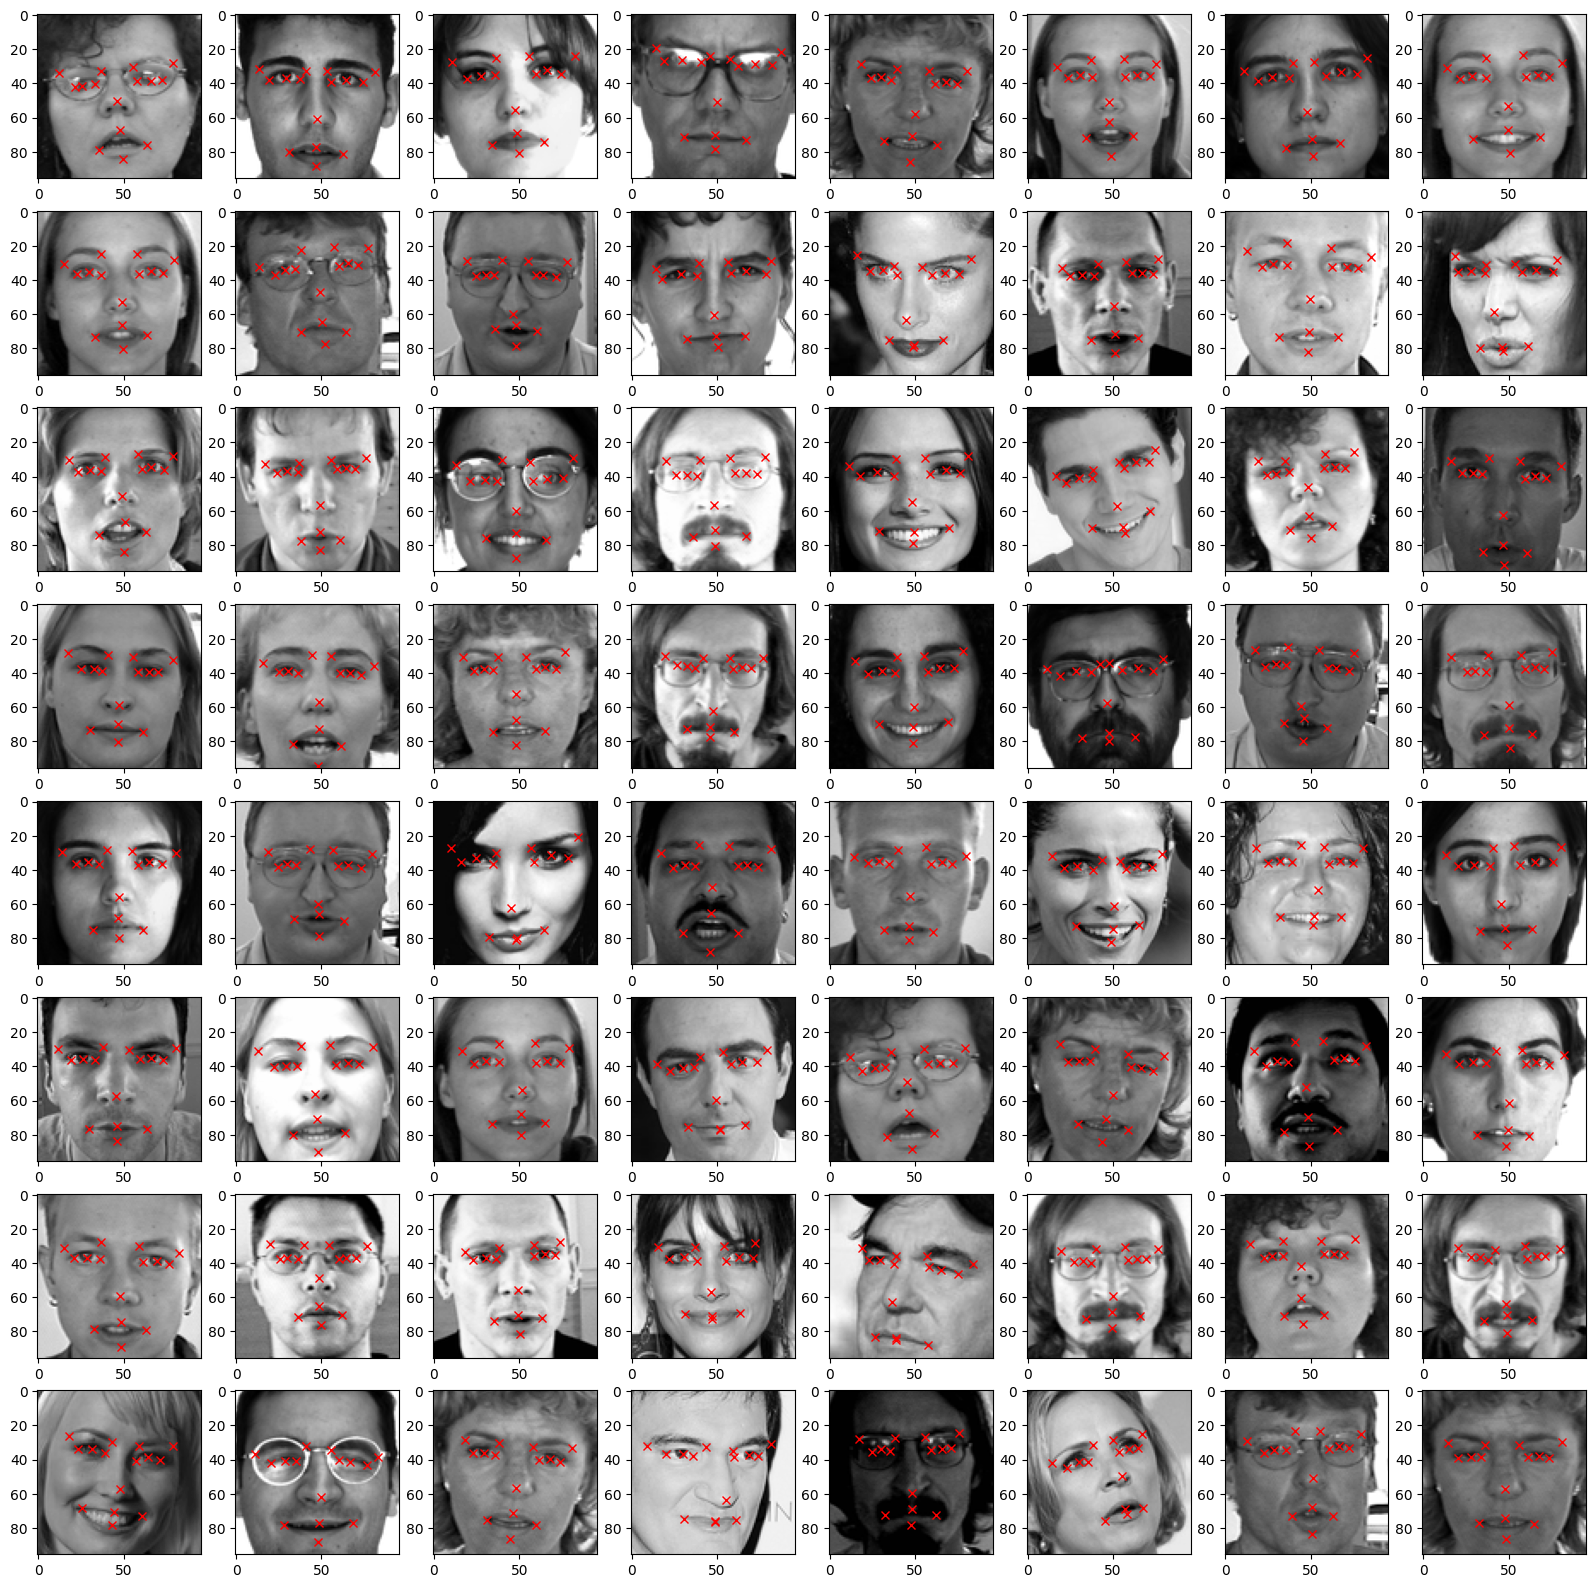

In [16]:
# Import the random module to select random indices for displaying images
import random

# Set up a figure with 20x20 inch size to display 64 images in an 8x8 grid
fig = plt.figure(figsize=(20, 20))

# Loop through 64 iterations to display 64 images
for i in range(64):
    # Randomly select an index from the dataset
    k = random.randint(1, len(keyfacial_df))

    # Add a subplot at the appropriate position in the 8x8 grid
    ax = fig.add_subplot(8, 8, i + 1)

    # Display the image at the selected index in grayscale
    image = plt.imshow(keyfacial_df['Image'][k], cmap='gray')

    # Plot the facial landmarks (x, y coordinates) as red 'x' markers
    for j in range(1, 31, 2):
        plt.plot(keyfacial_df.loc[k][j-1], keyfacial_df.loc[k][j], 'rx')


In [17]:
# Create a new copy of the dataframe
import copy
keyfacial_df_copy = copy.copy(keyfacial_df)

In [18]:
# Obtain the columns in the dataframe

columns = keyfacial_df_copy.columns[:-1]
columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')

In [19]:
# Horizontal Flip - flip the images along the y-axis (left-right flip)
keyfacial_df_copy['Image'] = keyfacial_df_copy['Image'].apply(lambda x: np.flip(x, axis=1))

# Since we are flipping horizontally, only the x-coordinate values will change.
# The y-coordinate values will remain the same.
# We update the x-coordinate by subtracting the initial x-coordinate values from the width of the image (96)
for i in range(len(columns)):
    # Check if the index is even (representing x-coordinates)
    if i % 2 == 0:
        # Update x-coordinates for flipped images
        keyfacial_df_copy[columns[i]] = keyfacial_df_copy[columns[i]].apply(lambda x: 96. - float(x))


<ipython-input-20-5b2aca50e5a0>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(keyfacial_df.loc[0][j-1], keyfacial_df.loc[0][j], 'rx')


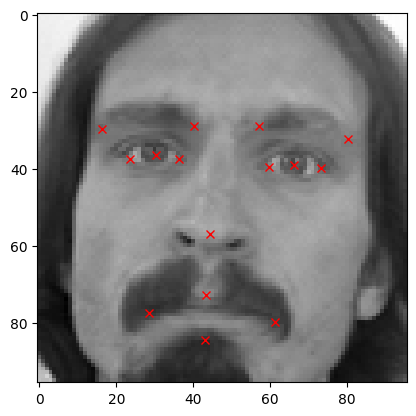

In [20]:
# Show the Original image
plt.imshow(keyfacial_df['Image'][0], cmap = 'gray')
for j in range(1, 31, 2):
        plt.plot(keyfacial_df.loc[0][j-1], keyfacial_df.loc[0][j], 'rx')

<ipython-input-21-fe6d77f074d9>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')


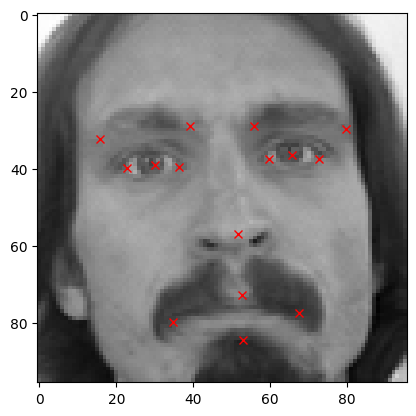

In [21]:
# Show the Horizontally flipped image
plt.imshow(keyfacial_df_copy['Image'][0],cmap='gray')
for j in range(1, 31, 2):
        plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')

In [22]:
# Concatenate the original dataframe with the augmented dataframe
augmented_df = np.concatenate((keyfacial_df, keyfacial_df_copy))

In [23]:
augmented_df.shape

(4280, 31)

In [24]:
# Randomly increasing the brightness of the images
# We multiply pixel values by random values between 1.5 and 2 to increase the brightness of the image.
# The pixel values are then clipped between 0 and 255 to ensure valid image pixel values.

import random

# Create a copy of the original dataframe to preserve the original data
keyfacial_df_copy = copy.copy(keyfacial_df)

# Apply a brightness increase by multiplying each pixel by a random value between 1.5 and 2, then clip the pixel values to the range [0, 255]
keyfacial_df_copy['Image'] = keyfacial_df_copy['Image'].apply(lambda x: np.clip(random.uniform(1.5, 2) * x, 0.0, 255.0))

# Concatenate the augmented data (with increased brightness) to the original augmented dataframe
augmented_df = np.concatenate((augmented_df, keyfacial_df_copy))

# Output the shape of the augmented dataframe
augmented_df.shape


(6420, 31)

<ipython-input-25-f778d7efe0bb>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')


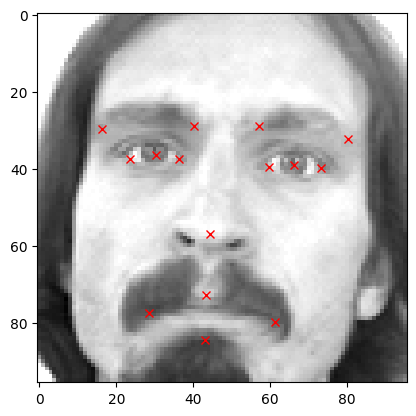

In [25]:
# Show Image with increased brightness

plt.imshow(keyfacial_df_copy['Image'][0], cmap='gray')
for j in range(1, 31, 2):
        plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')

In [26]:
# Create a copy of the original dataframe to preserve the original data
keyfacial_df_copy = copy.copy(keyfacial_df)


In [27]:
# Flip the images along the x-axis (vertical flip)
keyfacial_df_copy['Image'] = keyfacial_df_copy['Image'].apply(lambda x: np.flip(x, axis = 0))

# Adjust the x-coordinates for facial landmarks to match the flipped images
for i in range(len(columns)):
  if i % 2 == 1:  # Only apply the transformation to the x-coordinate columns (odd indices)
    keyfacial_df_copy[columns[i]] = keyfacial_df_copy[columns[i]].apply(lambda x: 96. - float(x))


<ipython-input-28-f460415fa385>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')


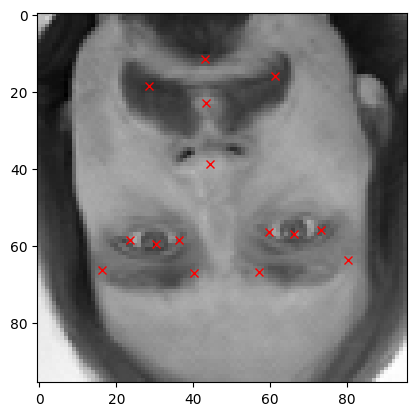

In [28]:
# Display the first image in the 'Image' column and overlay its facial landmarks
plt.imshow(keyfacial_df_copy['Image'][0], cmap='gray')

# Plot the facial landmarks (marked as red 'x') on the displayed image
for j in range(1, 31, 2):
    plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')


In [29]:
# Obtain the value of images which is present in the 31st column (since index start from 0, we refer to 31st column by 30)
img = augmented_df[:,30]

# Normalize the images
img = img/255.

# Create an empty array of shape (x, 96, 96, 1) to feed the model
X = np.empty((len(img), 96, 96, 1))

# Iterate through the img list and add image values to the empty array after expanding it's dimension from (96, 96) to (96, 96, 1)
for i in range(len(img)):
  X[i,] = np.expand_dims(img[i], axis = 2)

# Convert the array type to float32
X = np.asarray(X).astype(np.float32)
X.shape

(6420, 96, 96, 1)

In [30]:
# Obtain the value of x & y coordinates which are to used as target.
y = augmented_df[:,:30]
y = np.asarray(y).astype(np.float32)
y.shape

(6420, 30)

In [31]:
# Split the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [32]:
# Check the shape of the training dataset
X_train.shape

# Check the shape of the test dataset
X_test.shape


(1284, 96, 96, 1)

In [33]:
def res_block(X, filter, stage):
    """
    Builds a residual block with two main paths: one for convolution operations and another for identity mapping.
    The block includes convolutional layers, batch normalization, activation, and skip connections.

    Parameters:
    X (tensor): Input tensor to the residual block.
    filter (tuple): A tuple containing three integers representing the number of filters for the convolutional layers in the block.
                    (f1, f2, f3) where:
                    - f1 is the number of filters for the first 1x1 convolution.
                    - f2 is the number of filters for the 3x3 convolution.
                    - f3 is the number of filters for the second 1x1 convolution.
    stage (int): Integer indicating the stage of the block, used for naming purposes in the layers.

    Returns:
    X (tensor): The output tensor of the residual block after applying all convolutions, batch normalization, activation,
                and skip connections.
    """

    # Convolutional Block (Main Path)
    X_copy = X  # Create a copy of the input tensor for the short path

    f1, f2, f3 = filter  # Extract filter values

    # First convolution path
    X = Conv2D(f1, (1, 1), strides=(1, 1), name=f'res_{stage}_conv_a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = MaxPool2D((2, 2))(X)
    X = BatchNormalization(axis=3, name=f'bn_{stage}_conv_a')(X)
    X = Activation('relu')(X)

    # Second convolution path
    X = Conv2D(f2, (3, 3), strides=(1, 1), padding='same', name=f'res_{stage}_conv_b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=f'bn_{stage}_conv_b')(X)
    X = Activation('relu')(X)

    # Third convolution path
    X = Conv2D(f3, (1, 1), strides=(1, 1), name=f'res_{stage}_conv_c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=f'bn_{stage}_conv_c')(X)

    # Short Path (Identity Mapping)
    X_copy = Conv2D(f3, (1, 1), strides=(1, 1), name=f'res_{stage}_conv_copy', kernel_initializer=glorot_uniform(seed=0))(X_copy)
    X_copy = MaxPool2D((2, 2))(X_copy)
    X_copy = BatchNormalization(axis=3, name=f'bn_{stage}_conv_copy')(X_copy)

    # Adding the main and short paths (skip connection)
    X = Add()([X, X_copy])
    X = Activation('relu')(X)

    # Identity Block 1 (Repeat the pattern for additional convolutions and skip connections)
    X_copy = X  # Copy the output from the previous block

    # Main Path for Identity Block 1
    X = Conv2D(f1, (1, 1), strides=(1, 1), name=f'res_{stage}_identity_1_a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=f'bn_{stage}_identity_1_a')(X)
    X = Activation('relu')(X)

    X = Conv2D(f2, (3, 3), strides=(1, 1), padding='same', name=f'res_{stage}_identity_1_b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=f'bn_{stage}_identity_1_b')(X)
    X = Activation('relu')(X)

    X = Conv2D(f3, (1, 1), strides=(1, 1), name=f'res_{stage}_identity_1_c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=f'bn_{stage}_identity_1_c')(X)

    # Adding the main and identity paths (skip connection)
    X = Add()([X, X_copy])
    X = Activation('relu')(X)

    # Identity Block 2 (Repeat the pattern for another set of convolutions and skip connections)
    X_copy = X  # Copy the output from the previous block

    # Main Path for Identity Block 2
    X = Conv2D(f1, (1, 1), strides=(1, 1), name=f'res_{stage}_identity_2_a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=f'bn_{stage}_identity_2_a')(X)
    X = Activation('relu')(X)

    X = Conv2D(f2, (3, 3), strides=(1, 1), padding='same', name=f'res_{stage}_identity_2_b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=f'bn_{stage}_identity_2_b')(X)
    X = Activation('relu')(X)

    X = Conv2D(f3, (1, 1), strides=(1, 1), name=f'res_{stage}_identity_2_c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=f'bn_{stage}_identity_2_c')(X)

    # Adding the main and identity paths (skip connection)
    X = Add()([X, X_copy])
    X = Activation('relu')(X)

    return X


In [34]:
# Importing necessary libraries from TensorFlow Keras
from tensorflow.keras.layers import Input, ZeroPadding2D, Conv2D, BatchNormalization, Activation, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform

# Defining input shape, 96x96 grayscale images (1 channel)
input_shape = (96, 96, 1)

# Input layer, accepts images of shape (96, 96, 1)
X_input = Input(input_shape)
print("Input shape:", X_input.shape)

# Zero-padding to ensure dimensions remain after convolution
X = ZeroPadding2D((3, 3))(X_input)  # Padding by 3 on all sides
print("After ZeroPadding2D:", X.shape)

# First convolutional layer: applying 64 filters of size 7x7
X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
X = BatchNormalization(axis=3, name='bn_conv1')(X)  # Normalizing activations
X = Activation('relu')(X)  # ReLU activation for non-linearity
X = MaxPooling2D((3, 3), strides=(2, 2))(X)  # Max pooling with 3x3 window
print("After first stage:", X.shape)

# Residual blocks for deeper feature extraction with skip connections
# Stage 2: Using 64, 64, 256 filters in the residual block
X = res_block(X, filter=[64, 64, 256], stage=2)
print("After first res_block:", X.shape)

# Stage 3: Using 128, 128, 512 filters in the residual block
X = res_block(X, filter=[128, 128, 512], stage=3)
print("After second res_block:", X.shape)

# Stage 4: Using 256, 256, 1024 filters in the residual block
X = res_block(X, filter=[256, 256, 1024], stage=4)
print("After third res_block:", X.shape)

# Average pooling layer to downsample the feature maps
X = AveragePooling2D((2, 2), name='Average_Pooling')(X)  # Pooling with 2x2 window
print("After AveragePooling2D:", X.shape)

# Flattening the pooled output to connect to fully connected layers
X = Flatten()(X)
print("After Flatten:", X.shape)

# Fully connected layers to learn non-linear combinations of features
X = Dense(4096, activation='relu')(X)  # First dense layer with 4096 units and ReLU activation
X = Dropout(0.2)(X)  # Dropout layer with 20% rate to prevent overfitting
X = Dense(2048, activation='relu')(X)  # Second dense layer with 2048 units and ReLU activation
X = Dropout(0.1)(X)  # Dropout layer with 10% rate to prevent overfitting

# Output layer with 30 units (one for each facial keypoint coordinate)
X = Dense(30, activation='linear', name='output')(X)  # Linear activation for regression output

# Creating the model by specifying the input and output layers
model_1_facialKeyPoints = Model(inputs=X_input, outputs=X)

# Display the summary of the model, showing layer details, parameters, and output shapes
model_1_facialKeyPoints.summary()


Input shape: (None, 96, 96, 1)
After ZeroPadding2D: (None, 102, 102, 1)
After first stage: (None, 23, 23, 64)
After first res_block: (None, 11, 11, 256)
After second res_block: (None, 5, 5, 512)
After third res_block: (None, 2, 2, 1024)
After AveragePooling2D: (None, 1, 1, 1024)
After Flatten: (None, 1024)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 96, 96, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 102, 102, 1)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1 (Conv2D)            │ (None, 48, 48, 64)     │          3,200 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_conv1                  │ (None, 48, 48, 64)     │            256 │ conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 48, 48, 64)     │              0 │ bn_conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 23, 23, 64)     │              0 │ activation[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_2_conv_a (Conv2D)     │ (None, 23, 23, 64)     │          4,160 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 11, 11, 64)     │              0 │ res_2_conv_a[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_2_conv_a               │ (None, 11, 11, 64)     │            256 │ max_pooling2d_1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 11, 11, 64)     │              0 │ bn_2_conv_a[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_2_conv_b (Conv2D)     │ (None, 11, 11, 64)     │         36,928 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_2_conv_b               │ (None, 11, 11, 64)     │            256 │ res_2_conv_b[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 11, 11, 64)     │              0 │ bn_2_conv_b[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_2_conv_copy (Conv2D)  │ (None, 23, 23, 256)    │         16,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_2_conv_c (Conv2D)     │ (None, 11, 11, 256)    │         16,640 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 11, 11, 256)    │              0 │ res_2_conv_copy[0][0]  │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 17,585,694 (67.08 MB)

 Trainable params: 17,565,854 (67.01 MB)

 Non-trainable params: 19,840 (77.50 KB)

In [35]:
# Adam optimizer with custom learning rate, beta values, and amsgrad setting
adam = tf.keras.optimizers.Adam(
    learning_rate = 0.0001,  # Set the learning rate to 0.0001
    beta_1 = 0.9,            # Beta 1 value for the first moment estimate (controls the decay of the moving average of past gradients)
    beta_2 = 0.999,          # Beta 2 value for the second moment estimate (controls the decay of the moving average of past squared gradients)
    amsgrad = False          # Whether to use the AMSGrad variant of the Adam optimizer (defaults to False)
)

# Compiling the model with Mean Squared Error loss function for regression task
model_1_facialKeyPoints.compile(
    loss = "mean_squared_error",  # MSE is commonly used for regression tasks, where the output is continuous
    optimizer = adam,            # Use the Adam optimizer with the specified settings
    metrics = ['accuracy']       # Track accuracy during training, although accuracy is not very relevant for regression tasks
)

# Providing a link to the official TensorFlow documentation for the Adam optimizer
# For further details, you can check the official TensorFlow documentation:
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam


In [36]:
# save the best model with least validation loss
from tensorflow.keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(
    filepath="FacialKeyPoints_weights.keras",  # Use .keras extension
    verbose=1,
    save_best_only=True
)


In [37]:
# Training the model using the fit method
history = model_1_facialKeyPoints.fit(
    X_train,                  # Training data (features) to train the model
    y_train,                  # Training labels (ground truth) to compare the predictions against
    batch_size = 32,          # Number of samples per gradient update (controls how often the model weights are updated)
    epochs = 100,              # The number of times to iterate over the entire training dataset
    validation_split = 0.05,  # Use 5% of the training data as a validation set during training for performance evaluation
    callbacks=[checkpointer]  # List of callback functions to apply during training. 'checkpointer' is likely used to save the best model
)


Epoch 1/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.5824 - loss: 691.2703
Epoch 1: val_loss improved from inf to 754.61139, saving model to FacialKeyPoints_weights.keras
153/153 ━━━━━━━━━━━━━━━━━━━━ 75s 210ms/step - accuracy: 0.5825 - loss: 688.7408 - val_accuracy: 0.6809 - val_loss: 754.6114
Epoch 2/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6351 - loss: 113.0499
Epoch 2: val_loss improved from 754.61139 to 227.69533, saving model to FacialKeyPoints_weights.keras
153/153 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.6350 - loss: 113.0200 - val_accuracy: 0.6809 - val_loss: 227.6953
Epoch 3/100
151/153 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6128 - loss: 81.1668
Epoch 3: val_loss did not improve from 227.69533
153/153 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.6128 - loss: 81.1819 - val_accuracy: 0.6809 - val_loss: 241.6630
Epoch 4/100
152/153 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6174 - loss: 63.4031
Epoch 4: val_loss improved 

In [38]:
# Save the entire model
model_1_facialKeyPoints.save("FacialKeyPoints_model.keras")  # Use .keras or .h5 format


In [39]:
# Load the entire model
model_1_facialKeyPoints = tf.keras.models.load_model("FacialKeyPoints_model.keras")


In [40]:
# Evaluate the model

result = model_1_facialKeyPoints.evaluate(X_test, y_test)
print("Accuracy : {}".format(result[1]))

41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.6779 - loss: 72.4356
Accuracy : 0.6993769407272339


In [41]:
# Get the model keys
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

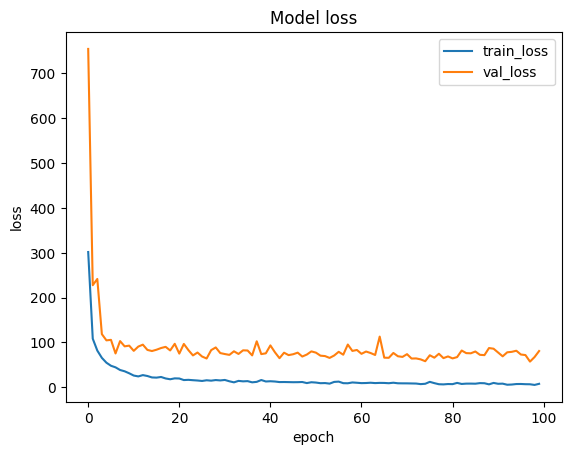

In [42]:
# Plot the training artifacts

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'upper right')
plt.show()

In [43]:
# read the csv files for the facial expression data
facialexpression_df = pd.read_csv('icml_face_data.csv')

In [45]:
# Accessing the first element in the 'pixels' column of the facialexpression_df DataFrame
# The value at index 0 is likely in string format, representing pixel data (usually an image in flattened form)
facialexpression_df[' pixels'][0]  # String format


'70 80 82 72 58 58 60 63 54 58 60 48 89 115 121 119 115 110 98 91 84 84 90 99 110 126 143 153 158 171 169 172 169 165 129 110 113 107 95 79 66 62 56 57 61 52 43 41 65 61 58 57 56 69 75 70 65 56 54 105 146 154 151 151 155 155 150 147 147 148 152 158 164 172 177 182 186 189 188 190 188 180 167 116 95 103 97 77 72 62 55 58 54 56 52 44 50 43 54 64 63 71 68 64 52 66 119 156 161 164 163 164 167 168 170 174 175 176 178 179 183 187 190 195 197 198 197 198 195 191 190 145 86 100 90 65 57 60 54 51 41 49 56 47 38 44 63 55 46 52 54 55 83 138 157 158 165 168 172 171 173 176 179 179 180 182 185 187 189 189 192 197 200 199 196 198 200 198 197 177 91 87 96 58 58 59 51 42 37 41 47 45 37 35 36 30 41 47 59 94 141 159 161 161 164 170 171 172 176 178 179 182 183 183 187 189 192 192 194 195 200 200 199 199 200 201 197 193 111 71 108 69 55 61 51 42 43 56 54 44 24 29 31 45 61 72 100 136 150 159 163 162 163 170 172 171 174 177 177 180 187 186 187 189 192 192 194 195 196 197 199 200 201 200 197 201 137 58 98 92

In [46]:
# function to convert pixel values in string format to array format

def string2array(x):
  return np.array(x.split(' ')).reshape(48, 48, 1).astype('float32')

In [47]:
# Resize images from (48, 48) to (96, 96)

def resize(x):

  img = x.reshape(48, 48)
  return cv2.resize(img, dsize=(96, 96), interpolation = cv2.INTER_CUBIC)

In [48]:
# Applying the string2array function to convert the string representation of pixel values into a numerical array
facialexpression_df[' pixels'] = facialexpression_df[' pixels'].apply(lambda x: string2array(x))

# Applying the resize function to resize each image (in array form) to a consistent shape
facialexpression_df[' pixels'] = facialexpression_df[' pixels'].apply(lambda x: resize(x))


In [49]:
facialexpression_df.head()

emotion                                             pixels
0        0  [[69.316925, 73.03865, 79.13719, 84.17186, 85....
1        0  [[151.09435, 150.91393, 150.65791, 148.96367, ...
2        2  [[23.061905, 25.50914, 29.47847, 33.99843, 36....
3        2  [[20.083221, 19.079437, 17.398712, 17.158691, ...
4        3  [[76.26172, 76.54747, 77.001785, 77.7672, 78.4...

In [50]:
# check the shape of data_frame
facialexpression_df.shape

(24568, 2)

In [51]:
# check for the presence of null values in the data frame
facialexpression_df.isnull().sum()

emotion    0
 pixels    0
dtype: int64

In [52]:
# Mapping integer labels to corresponding emotion names for facial expression classification
label_to_text = {0:'anger', 1:'disgust', 2:'sad', 3:'happiness', 4: 'surprise'}


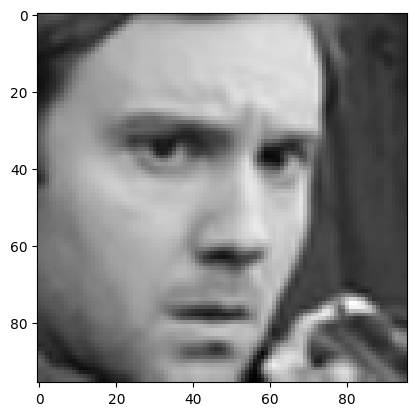

In [53]:
# Display the first image in the 'pixels' column of the facialexpression_df dataframe
# The image is shown in grayscale ('gray' colormap)
plt.imshow(facialexpression_df[' pixels'][0], cmap = 'gray')


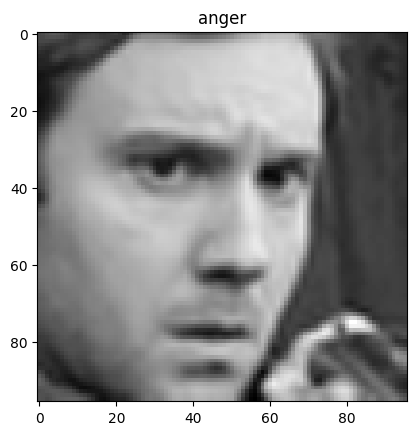

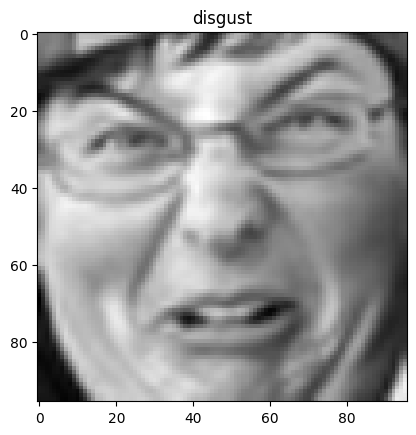

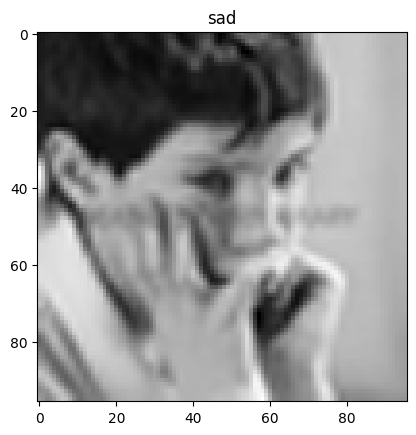

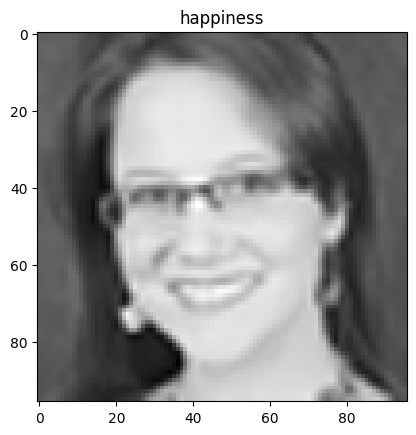

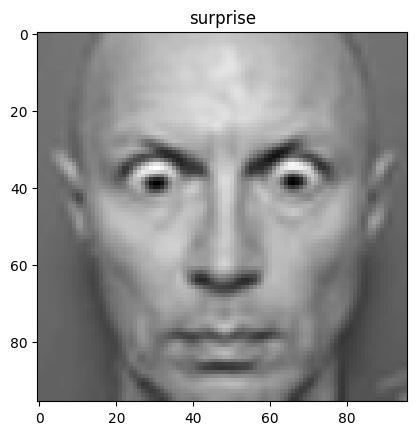

In [54]:
# List of emotions to display images for
emotions = [0, 1, 2, 3, 4]

# Loop through each emotion code (0 to 4)
for i in emotions:
    # Filter the dataframe to get the first image of each emotion (emotion code is 'i')
    data = facialexpression_df[facialexpression_df['emotion'] == i][:1]

    # Extract the image from the 'pixels' column
    img = data[' pixels'].item()

    # Reshape the image array to 96x96 pixels, as the images are originally in 1D format
    img = img.reshape(96, 96)

    # Create a new figure to display each image
    plt.figure()

    # Set the title of the plot to the corresponding emotion label using the 'label_to_text' dictionary
    plt.title(label_to_text[i])

    # Display the image in grayscale
    plt.imshow(img, cmap = 'gray')


In [55]:
# Display the unique emotion labels (indices) present in the 'emotion' column
facialexpression_df.emotion.value_counts().index

# Display the count of each emotion label (how many times each emotion occurs in the dataset)
facialexpression_df.emotion.value_counts()


emotion
3    8989
2    6077
0    4953
4    4002
1     547
Name: count, dtype: int64

<Axes: xlabel='emotion', ylabel='count'>

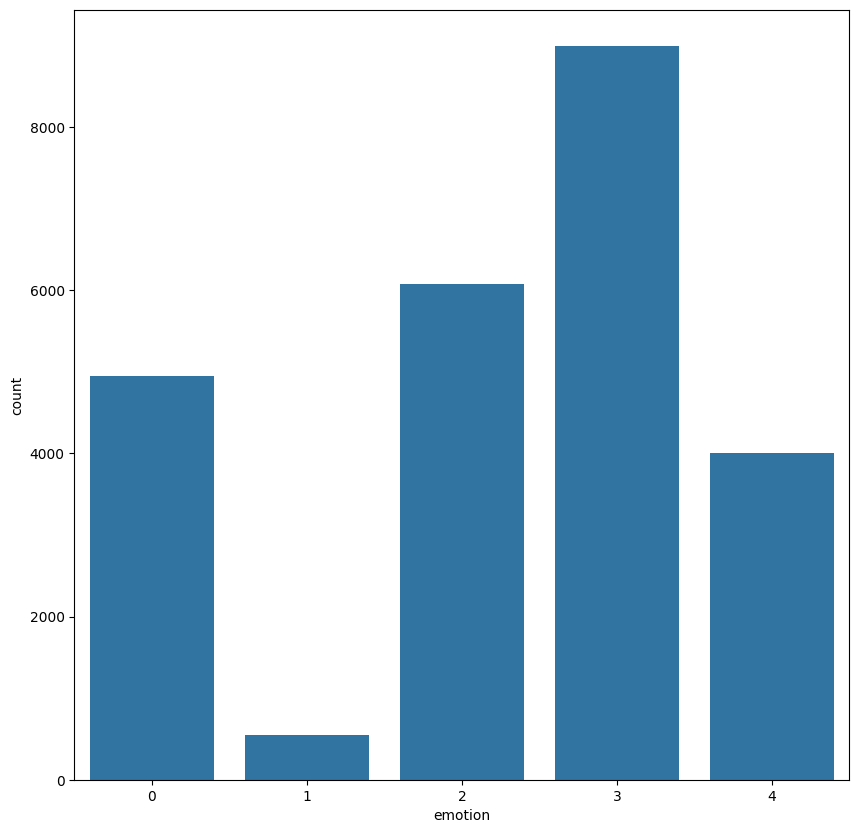

In [56]:
# Create a new figure with specified size
plt.figure(figsize = (10,10))

# Use seaborn's barplot to visualize the distribution of emotions
# The x-axis represents the unique emotion labels, and the y-axis represents their respective counts
sns.barplot(x = facialexpression_df.emotion.value_counts().index, y = facialexpression_df.emotion.value_counts())


In [57]:
# split the dataframe in to features and labels
from keras.utils import to_categorical

X = facialexpression_df[' pixels']
y = to_categorical(facialexpression_df['emotion'])


In [58]:
X[0]

array([[ 69.316925,  73.03865 ,  79.13719 , ...,  40.73619 ,  40.6584  ,
         40.5394  ],
       [ 68.66325 ,  70.95224 ,  74.71768 , ...,  43.274765,  42.037186,
         41.223618],
       [ 67.768814,  67.71646 ,  67.67172 , ...,  47.39473 ,  44.26329 ,
         42.31465 ],
       ...,
       [ 74.89021 ,  76.79553 ,  79.90259 , ...,  71.463425,  59.32875 ,
         51.74736 ],
       [ 76.68126 ,  75.808105,  74.25452 , ...,  93.943375,  79.77934 ,
         71.13246 ],
       [ 77.63858 ,  75.15074 ,  70.8846  , ..., 107.66351 ,  92.23212 ,
         82.91585 ]], dtype=float32)

In [59]:
y

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [60]:
# Stacking multiple arrays (X) along the first axis (axis=0)
# np.stack() combines arrays along a specified axis. Here, we are stacking all elements of X along axis 0.
X = np.stack(X, axis = 0)

# Reshaping the stacked array to have a shape of (24568, 96, 96, 1)
# This means that we are changing the shape of X to represent 24,568 grayscale images of size 96x96 with 1 channel (grayscale)
X = X.reshape(24568, 96, 96, 1)

# Printing the shapes of both X and y
# X is the input data (images) and y is the corresponding labels for those images
print(X.shape, y.shape)


(24568, 96, 96, 1) (24568, 5)


In [61]:
# split the dataframe in to train, test and validation data frames

from sklearn.model_selection import train_test_split

X_train, X_Test, y_train, y_Test = train_test_split(X, y, test_size = 0.1, shuffle = True)
X_val, X_Test, y_val, y_Test = train_test_split(X_Test, y_Test, test_size = 0.5, shuffle = True)


In [62]:
# Printing the shapes of the validation, test, and training datasets

# X_val and y_val represent the input images and labels for the validation set
# X_Test and y_Test represent the input images and labels for the test set
# X_train and y_train represent the input images and labels for the training set
# The shapes will show the number of samples and their corresponding dimensions and channels

print(X_val.shape, y_val.shape)  # Shape of validation set: (samples, height, width, channels)
print(X_Test.shape, y_Test.shape)  # Shape of test set: (samples, height, width, channels)
print(X_train.shape, y_train.shape)  # Shape of training set: (samples, height, width, channels)


(1228, 96, 96, 1) (1228, 5)
(1229, 96, 96, 1) (1229, 5)
(22111, 96, 96, 1) (22111, 5)


In [63]:
# image pre-processing

X_train = X_train/255
X_val   = X_val /255
X_Test  = X_Test/255

In [64]:
X_train

array([[[[0.28093764],
         [0.2841493 ],
         [0.2894596 ],
         ...,
         [0.59432113],
         [0.57725155],
         [0.5682922 ]],

        [[0.28263664],
         [0.28395253],
         [0.28606555],
         ...,
         [0.53720593],
         [0.545686  ],
         [0.5518442 ]],

        [[0.28538117],
         [0.28358057],
         [0.28043357],
         ...,
         [0.44384778],
         [0.49525207],
         [0.5268306 ]],

        ...,

        [[0.34632534],
         [0.33978823],
         [0.32957548],
         ...,
         [0.2531388 ],
         [0.2596989 ],
         [0.26363507]],

        [[0.3615025 ],
         [0.3549082 ],
         [0.34483236],
         ...,
         [0.28229964],
         [0.29013667],
         [0.29506853]],

        [[0.37095356],
         [0.3643432 ],
         [0.35438788],
         ...,
         [0.2999309 ],
         [0.308699  ],
         [0.3143289 ]]],


       [[[0.40564427],
         [0.40632054],
         [0.40

In [65]:
# Create an ImageDataGenerator instance for data augmentation
train_datagen = ImageDataGenerator(
    # Random rotation of images by up to 15 degrees
    rotation_range = 15,

    # Random horizontal shift of images by up to 10% of the width
    width_shift_range = 0.1,

    # Random vertical shift of images by up to 10% of the height
    height_shift_range = 0.1,

    # Random shear transformation with a shear angle of 10% (rotation or skew)
    shear_range = 0.1,

    # Random zoom transformation by up to 10%
    zoom_range = 0.1,

    # Randomly flip images horizontally
    horizontal_flip = True,

    # Strategy to fill in missing pixels after transformations
    # "nearest" will use the nearest pixel value for filling
    fill_mode = "nearest"
)


In [66]:
# Define input shape for the images (96x96 pixels with 1 channel, typically grayscale)
input_shape = (96, 96, 1)

# Create an input tensor with the given input shape
X_input = Input(input_shape)

# Apply zero-padding to the input to ensure that the dimensions are appropriate for convolution
X = ZeroPadding2D((3, 3))(X_input)

# First Convolutional Block (1st stage)
# Apply a Conv2D layer with 64 filters of size 7x7, and strides of (2, 2) for downsampling
X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)

# BatchNormalization to normalize the activations and help with training stability
X = BatchNormalization(axis=3, name='bn_conv1')(X)

# Apply ReLU activation to introduce non-linearity
X = Activation('relu')(X)

# Apply MaxPooling to downsample the feature maps and reduce spatial dimensions
X = MaxPooling2D((3, 3), strides=(2, 2))(X)

# Second Convolutional Block (2nd stage)
# Apply a residual block with filters [64, 64, 256] and stage number 2
X = res_block(X, filter=[64, 64, 256], stage=2)

# Third Convolutional Block (3rd stage)
# Apply another residual block with filters [128, 128, 512] and stage number 3
X = res_block(X, filter=[128, 128, 512], stage=3)

# Fourth Convolutional Block (4th stage)
# This stage is commented out, but it would have another residual block with filters [256, 256, 1024]
# X = res_block(X, filter=[256, 256, 1024], stage=4)

# Apply Average Pooling to reduce the feature map dimensions further
X = AveragePooling2D((4, 4), name='Averagea_Pooling')(X)

# Flatten the feature maps into a 1D vector to prepare for the final dense layer
X = Flatten()(X)

# Add a Dense layer with 5 units (for 5 emotion classes) and softmax activation for multi-class classification
X = Dense(5, activation='softmax', name='Dense_final', kernel_initializer=glorot_uniform(seed=0))(X)

# Create the model by specifying the input and output layers
model_2_emotion = Model(inputs=X_input, outputs=X, name='Resnet18')

# Display the model summary, which shows the architecture details
model_2_emotion.summary()


Model: "Resnet18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 96, 96, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 102, 102, 1)    │              0 │ input_layer_1[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1 (Conv2D)            │ (None, 48, 48, 64)     │          3,200 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_conv1                  │ (None, 48, 48, 64)     │            256 │ conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_28             │ (None, 48, 48, 64)     │              0 │ bn_conv1[0][0]         │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 23, 23, 64)     │              0 │ activation_28[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_2_conv_a (Conv2D)     │ (None, 23, 23, 64)     │          4,160 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 11, 11, 64)     │              0 │ res_2_conv_a[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_2_conv_a               │ (None, 11, 11, 64)     │            256 │ max_pooling2d_8[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_29             │ (None, 11, 11, 64)     │              0 │ bn_2_conv_a[0][0]      │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_2_conv_b (Conv2D)     │ (None, 11, 11, 64)     │         36,928 │ activation_29[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_2_conv_b               │ (None, 11, 11, 64)     │            256 │ res_2_conv_b[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_30             │ (None, 11, 11, 64)     │              0 │ bn_2_conv_b[0][0]      │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_2_conv_copy (Conv2D)  │ (None, 23, 23, 256)    │         16,640 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_2_conv_c (Conv2D)

 Total params: 1,174,021 (4.48 MB)

 Trainable params: 1,165,445 (4.45 MB)

 Non-trainable params: 8,576 (33.50 KB)

In [67]:
# train the network
model_2_emotion.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [68]:
# Import necessary callbacks for model training
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Early stopping callback to prevent overfitting by stopping training when the validation loss stops improving
# - `monitor='val_loss'`: Monitors the validation loss to check for improvement
# - `mode='min'`: Stops training when the quantity being monitored (validation loss) has stopped decreasing
# - `patience=20`: Number of epochs to wait for improvement before stopping the training
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# ModelCheckpoint callback to save the model weights only when the model has improved
# - `filepath="FacialExpression_weights.keras"`: Path to save the best model weights, with the .keras extension
# - `verbose=1`: Prints messages during training when the model is saved
# - `save_best_only=True`: Saves only the best weights based on the monitored metric (validation loss)
checkpointer = ModelCheckpoint(
    filepath="FacialExpression_weights.keras",  # Specify file path to save the best model weights
    verbose=1,
    save_best_only=True
)


In [69]:
# Train the model with data augmentation using ImageDataGenerator
history = model_2_emotion.fit(
    # Using the train_datagen (ImageDataGenerator) to augment the training data and feed it in batches of 64
    train_datagen.flow(X_train, y_train, batch_size=64),

    # Validation data (used to evaluate the model after each epoch)
    validation_data=(X_val, y_val),

    # Steps per epoch determines how many batches to process before completing an epoch
    steps_per_epoch=len(X_train) // 64,  # Dividing total training samples by batch size (64)

    # Number of epochs to train the model for
    epochs=100,

    # List of callbacks to use during training
    callbacks=[checkpointer, earlystopping]  # Saving the best model and applying early stopping
)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.4023 - loss: 1.5367
Epoch 1: val_loss improved from inf to 1.31181, saving model to FacialExpression_weights.keras
345/345 ━━━━━━━━━━━━━━━━━━━━ 81s 151ms/step - accuracy: 0.4026 - loss: 1.5359 - val_accuracy: 0.4349 - val_loss: 1.3118
Epoch 2/100
  1/345 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.5938 - loss: 0.8956

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 1.31181 to 1.30560, saving model to FacialExpression_weights.keras
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5938 - loss: 0.8956 - val_accuracy: 0.4397 - val_loss: 1.3056
Epoch 3/100
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.6252 - loss: 0.9485
Epoch 3: val_loss did not improve from 1.30560
345/345 ━━━━━━━━━━━━━━━━━━━━ 49s 94ms/step - accuracy: 0.6253 - loss: 0.9484 - val_accuracy: 0.3322 - val_loss: 1.5822
Epoch 4/100
  1/345 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.6250 - loss: 1.0996
Epoch 4: val_loss did not improve from 1.30560
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - accuracy: 0.6250 - loss: 1.0996 - val_accuracy: 0.3355 - val_loss: 1.5574
Epoch 5/100
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.6777 - loss: 0.8197
Epoch 5: val_loss improved from 1.30560 to 0.83542, saving model to FacialExpression_weights.keras
345/345 ━━━━━━━━━━━━━━━━━━━━ 35s 101ms/step - accuracy: 0.6778 - loss: 0.8196 - val_acc

In [70]:
model_2_emotion.save("FacialExpression_model.keras")  # Use `.keras` or `.h5`

In [71]:
model_2_emotion = tf.keras.models.load_model("FacialExpression_model.keras")

In [72]:
# Evaluate the model on the test data (X_Test, y_Test)
score = model_2_emotion.evaluate(X_Test, y_Test)

# Print the test accuracy (the second value in the score tuple, where score[1] is accuracy)
print('Test Accuracy: {}'.format(score[1]))


39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.7784 - loss: 0.6788
Test Accuracy: 0.7811228632926941


In [73]:
# Retrieve the keys of the training history dictionary
# history.history contains the training history with metrics like loss and accuracy
# This will return the names of the metrics recorded during training, such as 'loss', 'accuracy', 'val_loss', and 'val_accuracy'
print(history.history.keys())


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


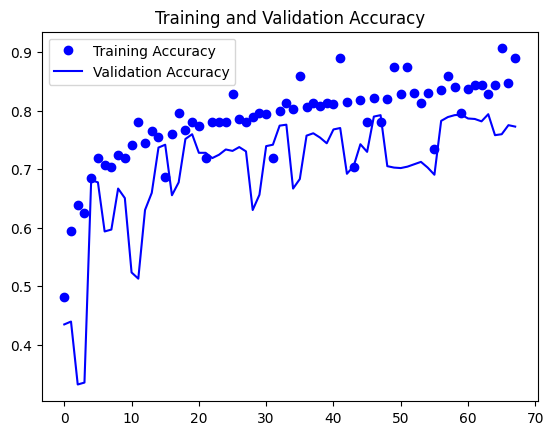

In [74]:
# Extract the accuracy, validation accuracy, loss, and validation loss from the training history
accuracy = history.history['accuracy']  # Training accuracy values
val_accuracy = history.history['val_accuracy']  # Validation accuracy values
loss = history.history['loss']  # Training loss values
val_loss = history.history['val_loss']  # Validation loss values

# Generate a range of epoch values based on the length of the accuracy list
epochs = range(len(accuracy))  # Total number of epochs

# Plot the training accuracy
plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')  # 'bo' means blue color and circle markers for training accuracy
# Plot the validation accuracy
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')  # 'b' means blue color for validation accuracy

# Set title for the plot
plt.title('Training and Validation Accuracy')  # Title of the plot

# Add legend to the plot to distinguish between training and validation accuracies
plt.legend()


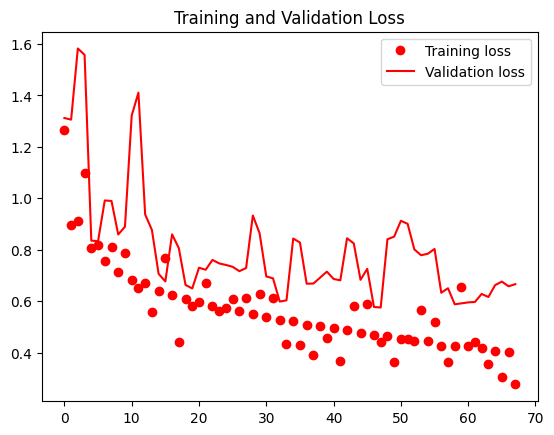

In [75]:
# Plot the training loss
plt.plot(epochs, loss, 'ro', label='Training loss')  # 'ro' means red color and circle markers for training loss
# Plot the validation loss
plt.plot(epochs, val_loss, 'r', label='Validation loss')  # 'r' means red color for validation loss

# Set title for the plot
plt.title('Training and Validation Loss')  # Title of the plot

# Add legend to the plot to distinguish between training and validation losses
plt.legend()


In [76]:
# predicted_classes = model.predict_classes(X_test)
predicted_classes = np.argmax(model_2_emotion.predict(X_Test), axis=-1)
y_true = np.argmax(y_Test, axis=-1)

39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step


In [77]:
y_true.shape

(1229,)

<Axes: >

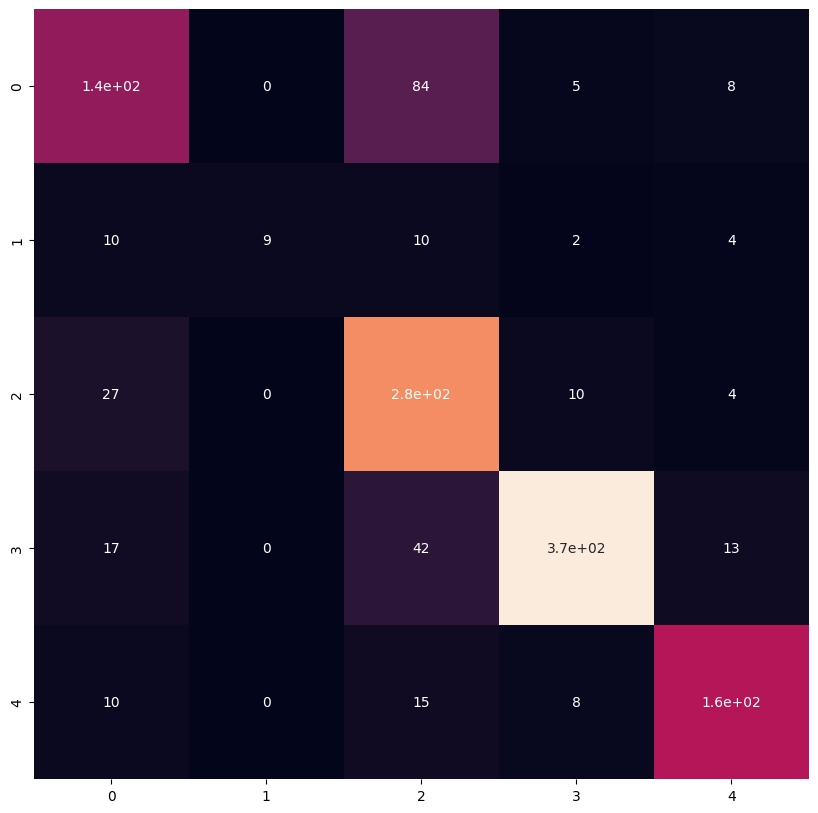

In [78]:
# Import confusion_matrix from scikit-learn to compute confusion matrix
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix by comparing true labels (y_true) and predicted labels (predicted_classes)
cm = confusion_matrix(y_true, predicted_classes)

# Create a figure with specified size for the heatmap plot
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot = True, cbar = False)

# Plot the confusion matrix as a heatmap using seaborn
# annot=True will annotate the heatmap with the actual numbers in the cells
# cbar=False removes the color


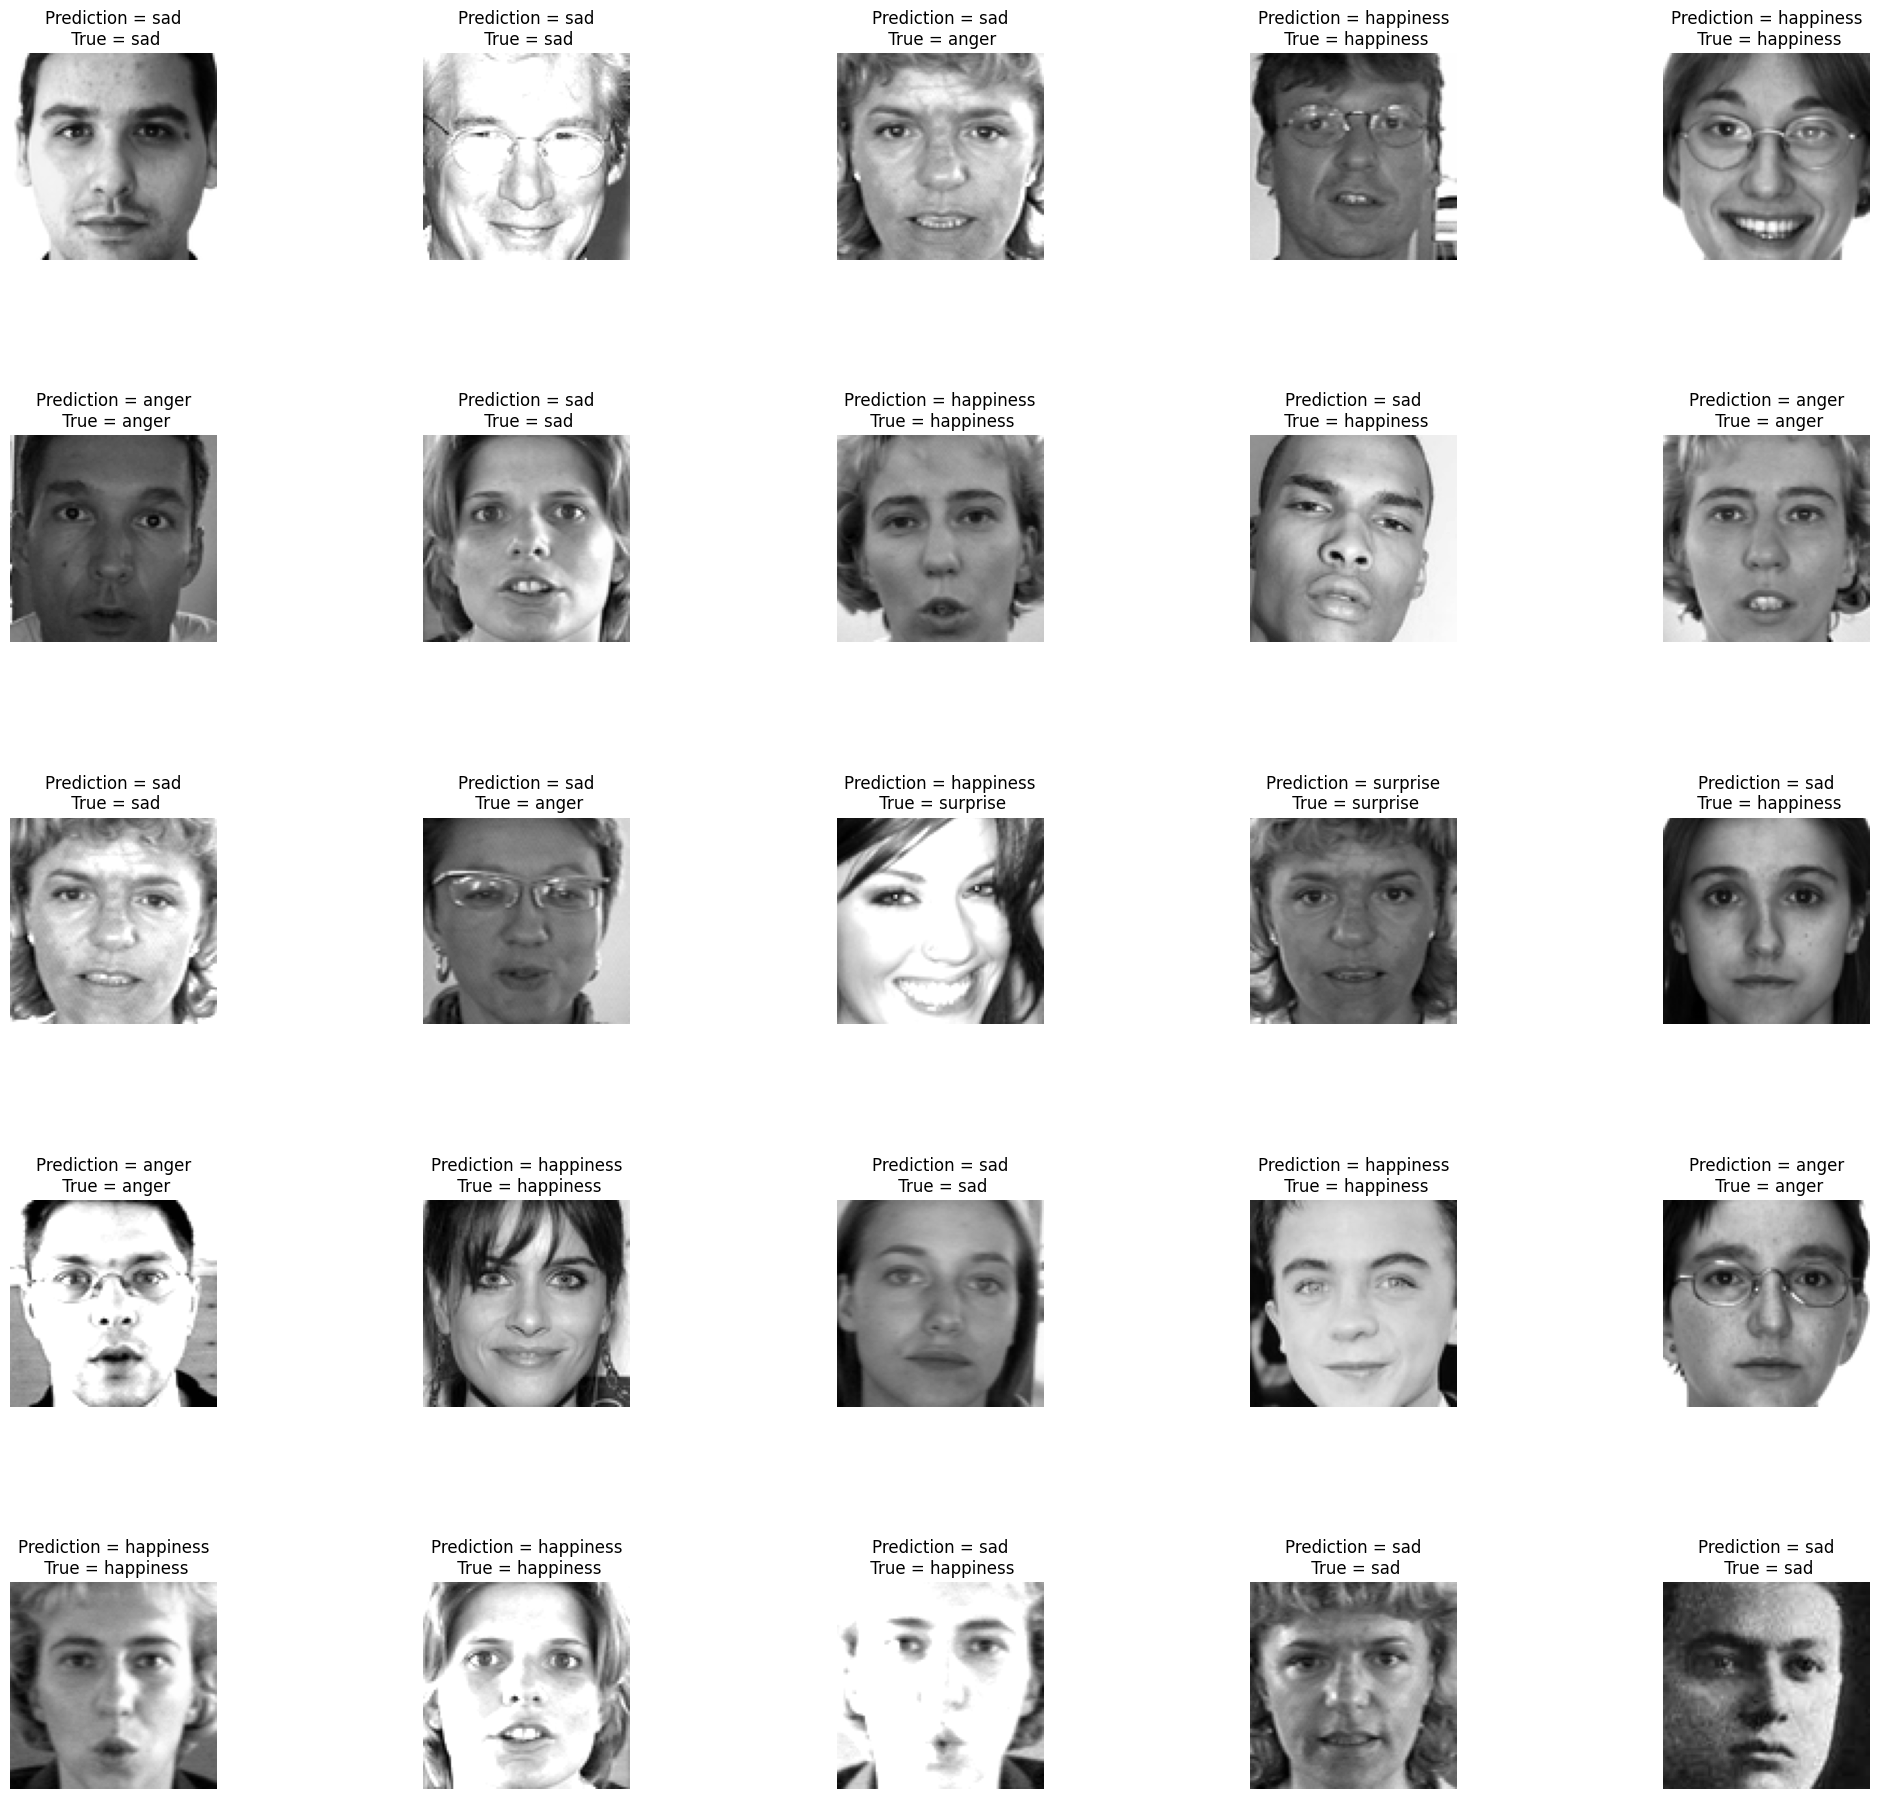

In [79]:
# L and W define the grid dimensions (number of rows and columns)
L = 5  # Number of rows
W = 5  # Number of columns

# Create a figure with subplots arranged in a grid (L x W) with a size of 24x24 inches
fig, axes = plt.subplots(L, W, figsize=(24, 24))

# Flatten the 2D array of axes into a 1D array for easier indexing
axes = axes.ravel()

# Loop through the range L*W to plot each image and its corresponding prediction/true label
for i in np.arange(0, L * W):
    # Display the image (X_test[i]) and reshape it to 96x96 pixels
    axes[i].imshow(X_test[i].reshape(96, 96), cmap='gray')

    # Set the title with the predicted label and the true label, using label_to_text for decoding
    axes[i].set_title('Prediction = {}\n True = {}'.format(label_to_text[predicted_classes[i]], label_to_text[y_true[i]]))

    # Remove the axis for a cleaner look
    axes[i].axis('off')

# Adjust the space between subplots to make the titles and images fit nicely
plt.subplots_adjust(wspace=1)


In [80]:
# Import the classification_report function from sklearn.metrics
from sklearn.metrics import classification_report

# Generate and print the classification report, which includes precision, recall, F1-score, and support for each class
print(classification_report(y_true, predicted_classes))


              precision    recall  f1-score   support

           0       0.68      0.58      0.63       232
           1       1.00      0.26      0.41        35
           2       0.65      0.87      0.75       323
           3       0.94      0.84      0.88       441
           4       0.85      0.83      0.84       198

    accuracy                           0.78      1229
   macro avg       0.82      0.68      0.70      1229
weighted avg       0.80      0.78      0.78      1229



In [81]:
def predict(X_test):

  # Making prediction from the keypoint model
  # The keypoint model predicts the coordinates of facial keypoints.
  df_predict = model_1_facialKeyPoints.predict(X_test)

  # Making prediction from the emotion model
  # The emotion model predicts the emotion (from 0 to 4) for each input.
  # np.argmax is used to get the class with the highest probability.
  df_emotion = np.argmax(model_2_emotion.predict(X_test), axis=-1)

  # Reshaping array from (856,) to (856,1)
  # The predicted emotion array is reshaped to match the expected input dimensions (856,1).
  df_emotion = np.expand_dims(df_emotion, axis = 1)

  # Converting the predictions (facial keypoints) into a DataFrame
  # Creating a DataFrame from the keypoint predictions with appropriate column names.
  df_predict = pd.DataFrame(df_predict, columns= columns)

  # Adding emotion into the predicted dataframe
  # Adding the predicted emotion (from emotion model) as a new column in the dataframe.
  df_predict['emotion'] = df_emotion

  # Returning the dataframe containing both keypoints and emotion predictions.
  return df_predict


In [82]:
df_predict = predict(X_test)

41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


In [83]:
df_predict.head()

left_eye_center_x  left_eye_center_y  right_eye_center_x  \
0          30.285404          35.713886           68.345512   
1          65.775009          40.357292           30.044256   
2          66.162735          38.780548           28.554516   
3          67.137306          32.809124           30.290339   
4          29.455620          36.621056           68.511299   

   right_eye_center_y  left_eye_inner_corner_x  left_eye_inner_corner_y  \
0           37.327415                38.071236                37.267021   
1           37.233643                58.559650                40.854008   
2           37.643818                58.858913                39.457104   
3           33.419460                61.330399                33.521385   
4           38.525967                37.658287                38.076374   

   left_eye_outer_corner_x  left_eye_outer_corner_y  right_eye_inner_corner_x  \
0                21.554653                36.333847                 59.999329   
1                73.452530                41.628593                 37.918316   
2                73.472313                39.742607                 35.683727   
3                72.729340                34.008583                 36.495945   
4                20.172701                37.203926                 59.991627   

   right_eye_inner_corner_y  ...  nose_tip_y  mouth_left_corner_x  \
0                 38.099178  ...   58.575657            31.337097   
1                 39.029388  ...   61.633202            61.659592   
2                 38.767715  ...   57.171524            62.916679   
3                 33.632259  ...   48.896290            62.507980   
4                 39.201004  ...   57.642021            29.089218   

   mouth_left_corner_y  mouth_right_corner_x  mouth_right_corner_y  \
0            75.643486             64.890472             76.830620   
1            78.468552             28.264606             76.053391   
2            76.013748             30.333927             75.411736   
3            72.266426             36.711712             71.236809   
4            75.699112             66.306557             77.269661   

   mouth_center_top_lip_x  mouth_center_top_lip_y  mouth_center_bottom_lip_x  \
0               48.220451               73.189110                  47.922768   
1               46.114815               77.300278                  45.416489   
2               46.872833               72.237991                  46.559734   
3               49.227531               64.537689                  49.308777   
4               48.276058               73.389771                  47.928833   

   mouth_center_bottom_lip_y  emotion  
0                  82.626793        2  
1                  82.140182        3  
2                  83.167747        4  
3                  78.532669        4  
4                  84.193237        3  

[5 rows x 31 columns]

<ipython-input-84-9e70d85e3c36>:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[i].plot(df_predict.loc[i][j-1], df_predict.loc[i][j], 'rx')


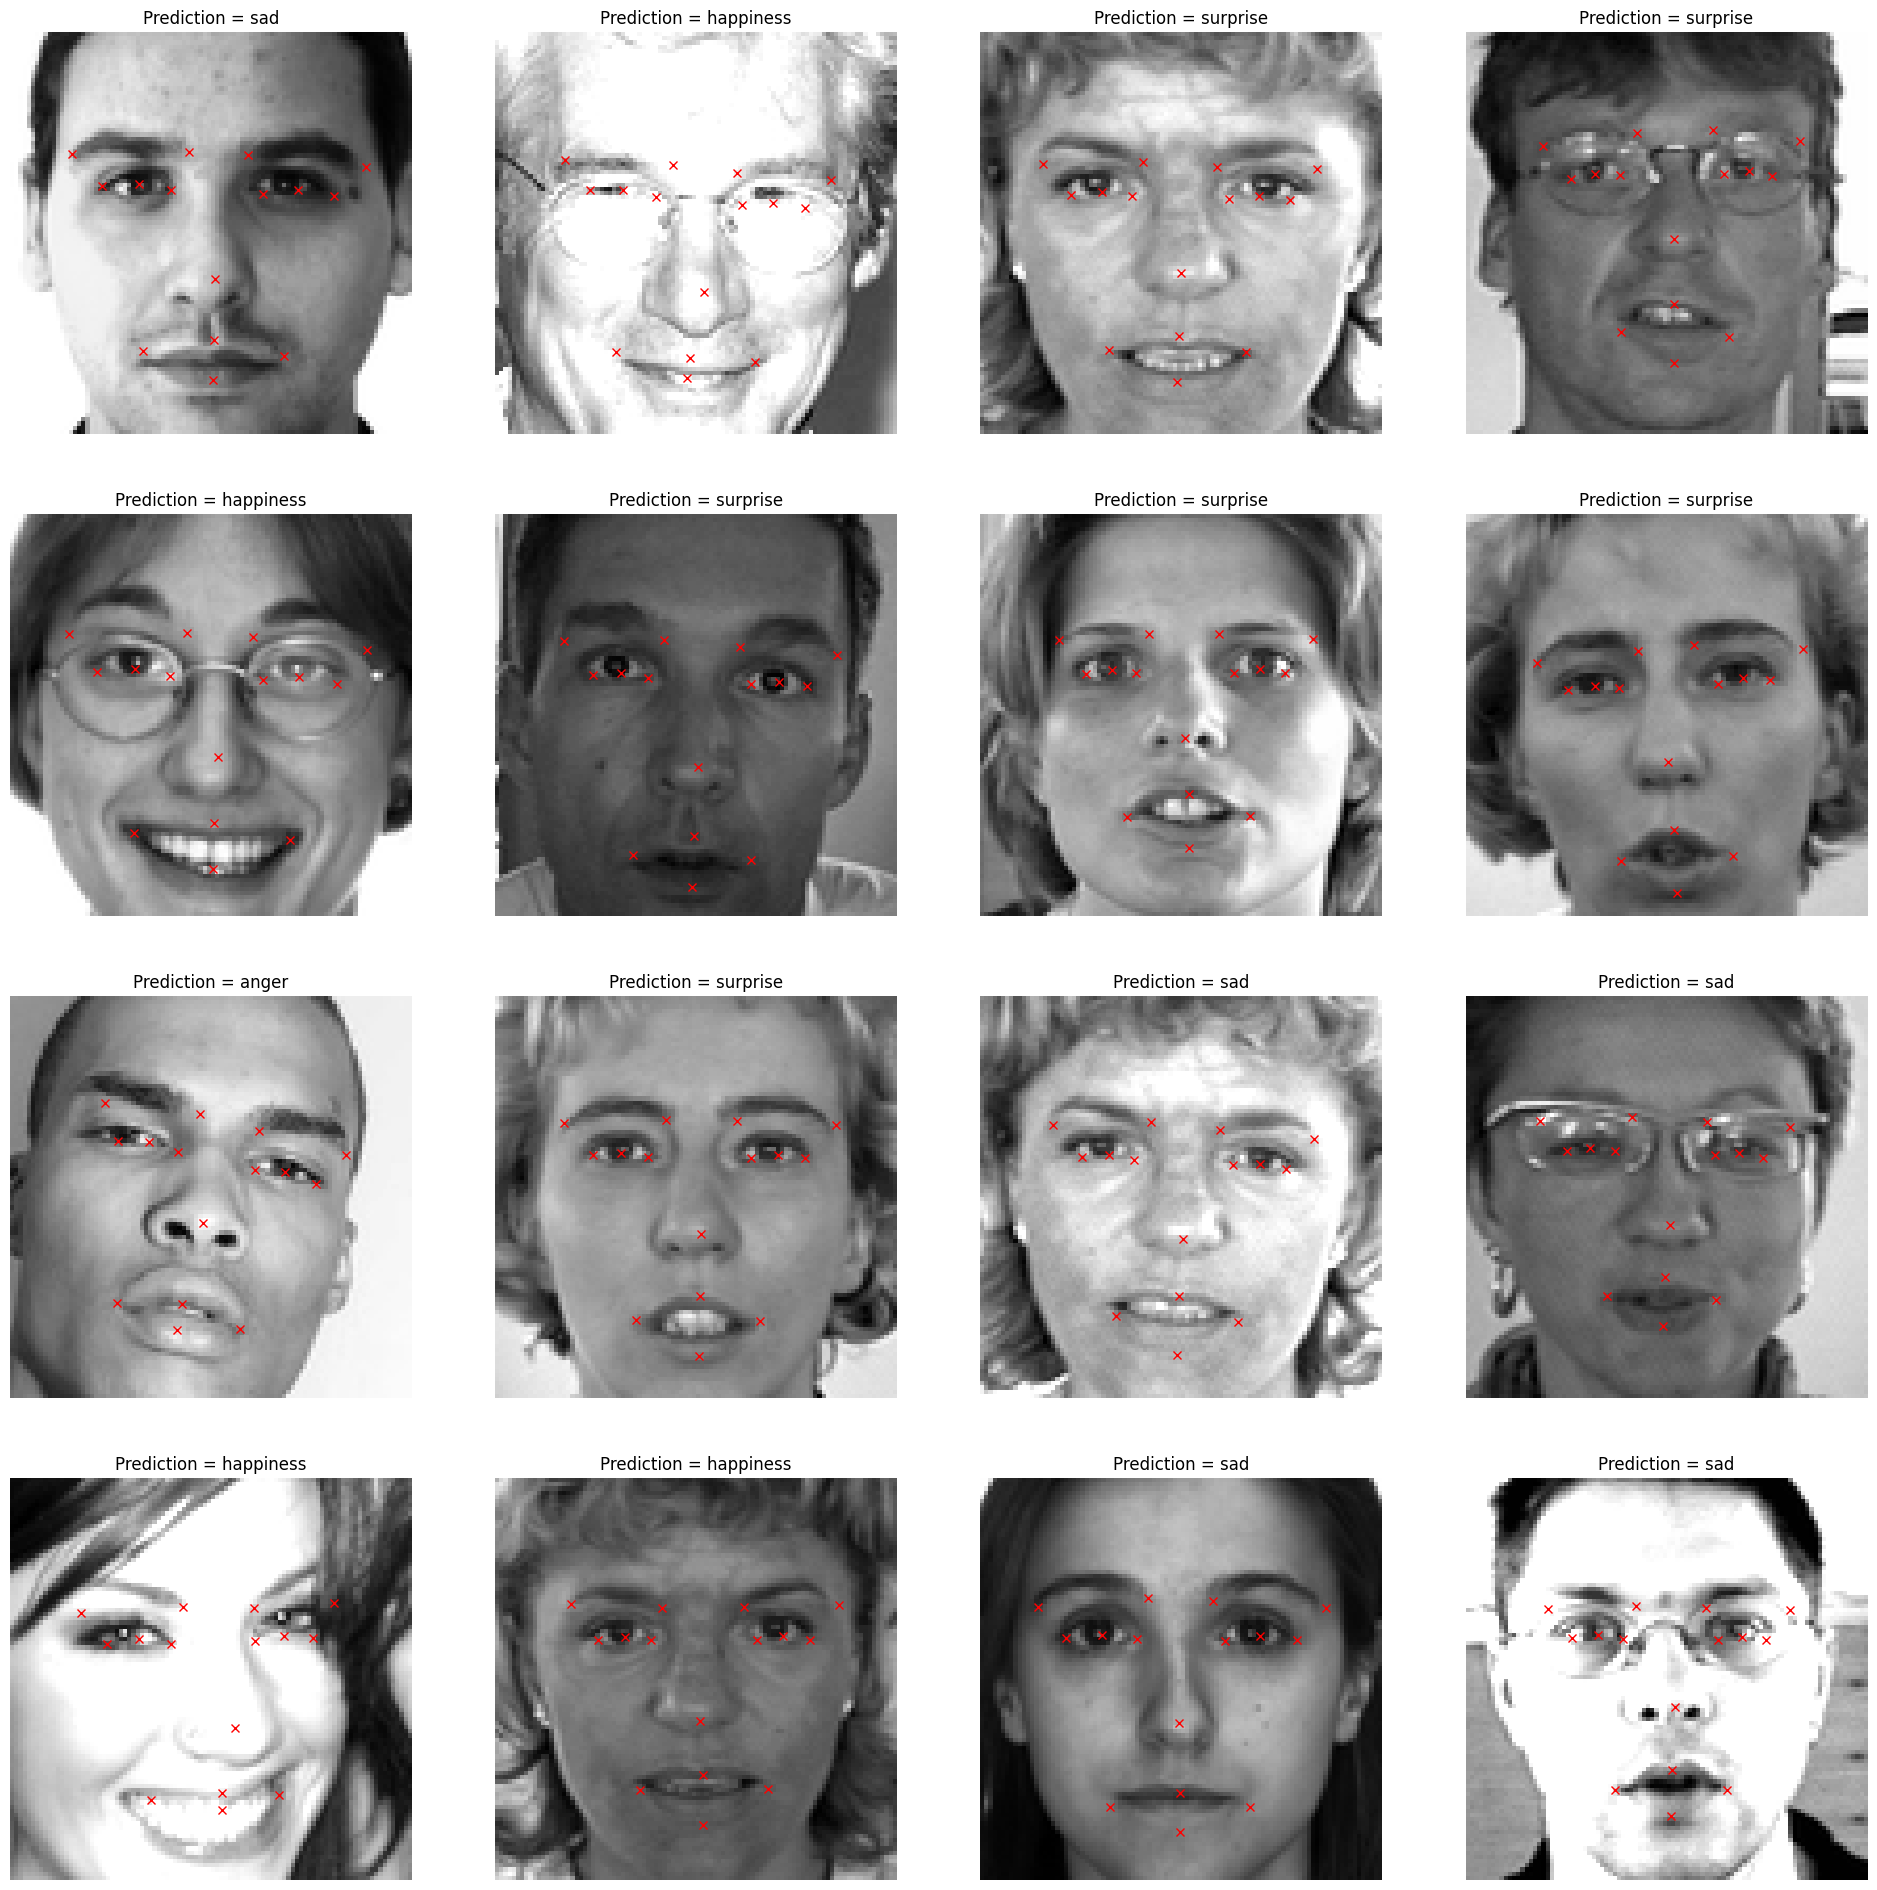

In [84]:
# Plotting the test images along with their predicted keypoints and emotions

# Create a grid of 4x4 subplots with a size of 24x24 inches
fig, axes = plt.subplots(4, 4, figsize = (24, 24))

# Flatten the axes array to make it easier to iterate over
axes = axes.ravel()

# Loop through the first 16 images from the test set
for i in range(16):

    # Display the i-th image from the test set with a grayscale colormap
    axes[i].imshow(X_test[i].squeeze(), cmap='gray')

    # Set the title of the subplot to the predicted emotion
    axes[i].set_title('Prediction = {}'.format(label_to_text[df_predict['emotion'][i]]))

    # Turn off the axis labels and ticks for better visualization
    axes[i].axis('off')

    # Loop through each keypoint (pairs of x, y coordinates)
    for j in range(1, 31, 2):  # j starts from 1, and increments by 2 to access x, y pairs
        # Plot each keypoint on the image using 'rx' (red x markers)
        axes[i].plot(df_predict.loc[i][j-1], df_predict.loc[i][j], 'rx')
